# Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)

<a id='intro'></a>
### Introduction

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. Our goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

# to get consistent results
random.seed(42)

`1.` Read in the `ab_data.csv` data and store it in `df`.

a. Read in the dataset and take a look at the top few rows

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. The number of rows in the dataset:

In [3]:
df.shape[0]

294478

c. The number of unique users in the dataset:

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted:

In [5]:
df.converted.sum() / df.shape[0]

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match:

In [6]:
#save indexes to drop them further
dm_ind = df[((df['group'] == 'treatment') == (
    df['landing_page'] == 'new_page')) == False].index
len(dm_ind)

3893

f. Do any of the rows have missing values?

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are no missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Create a new dataset that meets the specifications by dropping the rows with unclear data.

In [8]:
#drop saved indexes
df2 = df.drop(dm_ind)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Let's try to answer some questions about data.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [11]:
df2[df2.user_id.duplicated()].user_id.values[0]

773192

c. What is the row information for the repeat **user_id**? 

In [12]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**.

In [13]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

`4.` Let's try to answer more questions about data.

a. What is the probability of an individual converting regardless of the page they receive?

In [14]:
df_cmean = df2.converted.mean()
df_cmean

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [15]:
dfc = df2[df2.group == 'control']
dfc_cmean = dfc.converted.mean()
dfc_cmean

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [16]:
dft = df2[df2.group == 'treatment']
dft_cmean = dft.converted.mean()
dft_cmean

0.11880806551510564

d. What is the probability that an individual received the new page?

In [17]:
(df2.landing_page == 'new_page').mean()

0.5000619442226688

**By considering our results from parts (a) through (d) above, there is no sufficient evidence the new treatment page leads to more conversions. In every case the probability is around 12% and differs insignificantly from others.** 

<a id='ab_test'></a>
### Part II - A/B Test

`1.` For now, consider we need to make the decision just based on all the data provided. We want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%. Let's state our hypothesis in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{new} - p_{old} <= 0$$
$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Let's perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [18]:
#p_new and p_old are equal under the null
p_new = df_cmean
p_new

0.11959708724499628

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [19]:
#p_new and p_old are equal under the null
p_old = df_cmean
p_old

0.11959708724499628

c. What is $n_{new}$, the number of individuals in the treatment group?

In [20]:
n_new = dft.shape[0]
n_new

145310

d. What is $n_{old}$, the number of individuals in the control group?

In [21]:
n_old = dfc.shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [22]:
new_page_converted = np.random.binomial(1, p_new, n_new)

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.binomial(1, p_old, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [24]:
new_page_converted.mean() - old_page_converted.mean()

5.263744068957632e-05

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [25]:
p_diffs = []
new_page_converted = np.random.binomial(n_new, p_new, 10000) / n_new
old_page_converted = np.random.binomial(n_old, p_old, 10000) / n_old
p_diffs = new_page_converted - old_page_converted
p_diffs

array([ 0.00080315,  0.00133321,  0.00223468, ..., -0.00108259,
       -0.00035975, -0.00048391])

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

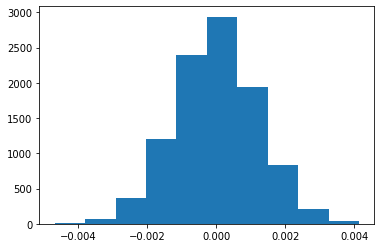

In [26]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [27]:
(p_diffs > (dft_cmean - dfc_cmean)).mean()

0.9055

**We computed p-value for our data and hypothesis. The value 90% is much higher than Type I error rate of 5%. It means that we fail to reject our null hypothesis.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.

In [28]:
import statsmodels.api as sm

#calculate only converted
convert_old = dfc.converted.sum()
convert_new = dft.converted.sum()

#calculate overall numbers
n_old = len(dfc)
n_new = len(dft)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [29]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old],
                                              [n_new, n_old],
                                              alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

**According to calculated z-score and p-value we failed to reject the null hypothesis again. Our findings in parts j. and k. agree with the values we got from statsmodels library.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, we should perform a logistic regression in this case.

b. We will use **statsmodels** to fit the regression model we specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, we first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2.group)['treatment']

c. Use **statsmodels** to instantiate our regression model on the two columns we created in part b., then fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [31]:
# Instantiating the model
lm = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
# Fitting the model
res = lm.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of our model.

In [32]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Fri, 22 May 2020   Pseudo R-squ.:               8.077e-06
Time:                        14:03:32   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. **P-value from logistic regression is 0.19 and significantly lower than we calculated earlier. The difference is because logistic regression uses a different hypothesis:**
$$H_0: p_{new} - p_{old} = 0$$
$$H_1: p_{new} - p_{old} \neq 0$$

f. **Many factors can influence statistics. The more factors we consider in our model the less statistical mistakes we can make. Previous analysis showed that the type of group has no impact on conversion. So it is definitely a good idea to check other data.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. We read in the **countries.csv** dataset and merge together our datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables.

In [33]:
#load data
cdf = pd.read_csv('./countries.csv')
#join
cdf = cdf.set_index('user_id').join(df2.set_index('user_id'), how='inner')
#dummy variables
cdf[['CA', 'UK', 'US']] = pd.get_dummies(cdf['country'])
cdf.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


Let's check if country had an impact on conversion.

In [34]:
# Instantiating the model
lm = sm.Logit(cdf['converted'], cdf[['intercept', 'CA', 'UK']])
# Fitting the model
res = lm.fit()
# Displaying summary results
res.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 22 May 2020   Pseudo R-squ.:               1.521e-05
Time:                        14:03:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**The p-values for the countries are higher than 5% error rate. So we can conclude that countries alone don't influence conversion significantly.**

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.

In [35]:
# Instantiating the model
lm = sm.Logit(cdf['converted'], cdf[['intercept', 'ab_page', 'CA', 'UK']])
# Fitting the model
res = lm.fit()
# Displaying summary results
res.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 22 May 2020   Pseudo R-squ.:               2.323e-05
Time:                        14:03:34   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**The p-values for the countries and the ab_page are greater than 5% error rate. We can conclude that an interaction between page and country doesn't have any significant effect on conversion.**

<a id='conclusions'></a>
## Conclusions
The analysis results showed that we have no sufficient evidence to claim that the new page has a higher conversion rate than the old one. We found that the page alone, a country, and an interaction between page and country don't have any effect on a conversion rate. According to our data analysis, we recommend the company not use the new page.